In [5]:
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.nn.functional as F
from torch.utils import data
import torch.nn as nn
import torch.optim as optim
from multiprocessing import Pool

In [6]:
device = torch.device("mps" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
path = './data/cu.parquet'

data = pd.read_parquet(path)
data.replace(-121, np.nan, inplace=True)
print(set(data['TradingDay'].values))
data = data[['TradingDay', 'LastPrice', 'PreSettlementPrice', 'PreClosePrice',
             'PreOpenInterest', 'OpenPrice', 'HighestPrice', 'LowestPrice', 'OpenInterest',
             'BidPrice1', 'BidVolume1', 'AskPrice1', 'AskVolume1',
             'BidPrice2', 'BidVolume2', 'AskPrice2', 'AskVolume2',
             'BidPrice3', 'BidVolume3', 'AskPrice3', 'AskVolume3',
             'BidPrice4', 'BidVolume4', 'AskPrice4', 'AskVolume4',
             'BidPrice5', 'BidVolume5', 'AskPrice5', 'AskVolume5',
             'delta_Volume', 'delta_Turnover']]
data

{20231201, 20231204, 20231205, 20231206, 20231207, 20231208, 20231211, 20231212, 20231213, 20231214, 20230703, 20230704, 20230705, 20230706, 20230707, 20231215, 20231218, 20230710, 20230711, 20230712, 20230201, 20230202, 20230203, 20230713, 20230714, 20230206, 20230207, 20230208, 20230209, 20230210, 20230717, 20230718, 20230213, 20230214, 20230215, 20230216, 20230217, 20230721, 20230724, 20230220, 20230221, 20230222, 20230223, 20230224, 20230728, 20230731, 20230227, 20230228, 20231117, 20231219, 20231220, 20231221, 20230801, 20230802, 20230803, 20230804, 20230807, 20230808, 20230809, 20230810, 20230811, 20231120, 20230301, 20230302, 20230303, 20230814, 20230815, 20230306, 20230307, 20230308, 20230309, 20230310, 20230816, 20230817, 20230313, 20230314, 20230315, 20230316, 20230317, 20230821, 20230822, 20230320, 20230321, 20230322, 20230323, 20230324, 20230828, 20230829, 20230327, 20230328, 20230329, 20230330, 20230331, 20231020, 20231121, 20231122, 20231123, 20230818, 20231225, 20231124,

,TradingDay,LastPrice,PreSettlementPrice,PreClosePrice,PreOpenInterest,OpenPrice,HighestPrice,LowestPrice,OpenInterest,BidPrice1,...,BidPrice4,BidVolume4,AskPrice4,AskVolume4,BidPrice5,BidVolume5,AskPrice5,AskVolume5,delta_Volume,delta_Turnover
2023-01-03 08:59:00.500,20230103,66160,66120,66260,99641,66160,66160,66160,99658,66160,...,66130,200,66260,110,66120,13,66270,30,224.0,74099200.0
2023-01-03 09:00:00.500,20230103,66240,66120,66260,99641,66160,66240,66160,99669,66210,...,66160,160,66270,2,66150,353,66280,1,21.0,6952600.0
2023-01-03 09:00:01.000,20230103,66210,66120,66260,99641,66160,66240,66160,99682,66210,...,66160,161,66260,102,66150,353,66270,2,56.0,18541250.0
2023-01-03 09:00:01.500,20230103,66230,66120,66260,99641,66160,66240,66160,99681,66230,...,66200,27,66270,3,66170,64,66280,1,14.0,4636150.0
2023-01-03 09:00:02.000,20230103,66230,66120,66260,99641,66160,66250,66160,99672,66230,...,66200,28,66300,56,66170,63,66310,1,29.0,9603500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-29 14:59:59.000,20231229,68920,69500,69340,155933,68970,69150,68810,144501,68910,...,68880,8,68950,4,68870,4,68960,2,8.0,2756650.0
2023-12-29 14:59:59.500,20231229,68920,69500,69340,155933,68970,69150,68810,144501,68920,...,68890,10,68960,2,68880,8,68970,11,1.0,344600.0
2023-12-29 15:00:00.000,20231229,68920,69500,69340,155933,68970,69150,68810,144501,68920,...,68890,10,68960,2,68880,8,68970,11,1.0,344600.0
2023-12-29 15:00:00.500,20231229,68920,69500,69340,155933,68970,69150,68810,144501,68920,...,68890,10,68960,2,68880,8,68970,11,0.0,0.0


In [8]:
feature_cols = ['BidPrice1', 'BidVolume1', 'AskPrice1', 'AskVolume1',
             'BidPrice2', 'BidVolume2', 'AskPrice2', 'AskVolume2',
             'BidPrice3', 'BidVolume3', 'AskPrice3', 'AskVolume3',
             'BidPrice4', 'BidVolume4', 'AskPrice4', 'AskVolume4',
             'BidPrice5', 'BidVolume5', 'AskPrice5', 'AskVolume5',
             'delta_Volume', 'delta_Turnover']

# feature_cols = ['BidPrice1', 'BidVolume1', 'AskPrice1', 'AskVolume1',
#              'BidPrice2', 'BidVolume2', 'AskPrice2', 'AskVolume2',
#              'BidPrice3', 'BidVolume3', 'AskPrice3', 'AskVolume3',
#              'BidPrice4', 'BidVolume4', 'AskPrice4', 'AskVolume4',
#              'BidPrice5', 'BidVolume5', 'AskPrice5', 'AskVolume5']

price_cols = ['BidPrice1', 'AskPrice1', 'BidPrice2',
              'AskPrice2', 'BidPrice3', 'AskPrice3',
              'BidPrice4', 'AskPrice4', 'BidPrice5', 'AskPrice5']

vol_cols = ['BidVolume1', 'AskVolume1', 'BidVolume2', 'AskVolume2',
            'BidVolume3', 'AskVolume3', 'BidVolume4', 'AskVolume4',
            'BidVolume5', 'AskVolume5']

In [9]:
def data_preprocess(raw_data, ret_window = 120):
    raw_data['midprice'] = (raw_data['BidPrice1']+raw_data['AskPrice1'])/2
    raw_data['fut_midprice'] = raw_data['midprice'].shift(-ret_window)
    raw_data['label'] = 100*(raw_data['fut_midprice']-raw_data['midprice'])/raw_data['midprice']

    raw_data['midvolume'] = (raw_data['BidVolume1']+raw_data['AskVolume1'])/2

    # price_rolling_mean = raw_data['midprice'].rolling(window=10).mean()
    # volume_rolling_mean = raw_data['midvolume'].rolling(window=10).mean()

    # raw_data['rolling_midprice'] = price_rolling_mean
    # raw_data['rolling_midvolume'] = volume_rolling_mean

    raw_data.drop(raw_data.tail(ret_window).index, inplace=True)
    raw_data.drop(raw_data.head(10).index, inplace=True)

    label = raw_data[['label']].values

    # raw_data[vol_cols] = raw_data[vol_cols].div(raw_data['rolling_midvolume'], axis=0)
    # raw_data[price_cols] = raw_data[price_cols].div(raw_data['rolling_midprice'], axis=0)-1
    # raw_data[price_cols] = 10000*raw_data[price_cols]
    # raw_data[vol_cols] = np.log(raw_data[vol_cols])
    raw_data = raw_data[feature_cols].values

    return raw_data, label

In [10]:
dataset = data_preprocess(data)
del data
dataset

(array([[6.621000e+04, 2.290000e+02, 6.622000e+04, ..., 1.020000e+02,
         4.600000e+01, 1.522470e+07],
        [6.621000e+04, 1.990000e+02, 6.623000e+04, ..., 3.000000e+00,
         5.600000e+01, 1.853955e+07],
        [6.622000e+04, 4.000000e+00, 6.623000e+04, ..., 2.000000e+00,
         3.800000e+01, 1.258075e+07],
        ...,
        [6.890000e+04, 5.500000e+01, 6.891000e+04, ..., 4.400000e+01,
         0.000000e+00, 0.000000e+00],
        [6.890000e+04, 5.500000e+01, 6.891000e+04, ..., 4.400000e+01,
         0.000000e+00, 0.000000e+00],
        [6.890000e+04, 5.000000e+01, 6.891000e+04, ..., 4.400000e+01,
         0.000000e+00, 0.000000e+00]]),
 array([[-0.04530695],
        [-0.05285412],
        [-0.06040015],
        ...,
        [ 0.02902547],
        [ 0.02902547],
        [ 0.02902547]]))

(array([6.000000e+01, 1.590000e+02, 2.100000e+01, 9.900000e+01,
        1.540000e+02, 1.010000e+02, 1.570000e+02, 3.420000e+02,
        7.620000e+02, 1.379000e+03, 5.132000e+03, 4.062100e+04,
        7.732389e+06, 3.898390e+05, 5.676000e+03, 2.859000e+03,
        1.150000e+03, 5.320000e+02, 3.980000e+02, 2.590000e+02]),
 array([-2.32287191, -2.13952693, -1.95618195, -1.77283697, -1.58949198,
        -1.406147  , -1.22280202, -1.03945703, -0.85611205, -0.67276707,
        -0.48942208, -0.3060771 , -0.12273212,  0.06061287,  0.24395785,
         0.42730283,  0.61064782,  0.7939928 ,  0.97733778,  1.16068276,
         1.34402775]),
 <BarContainer object of 20 artists>)

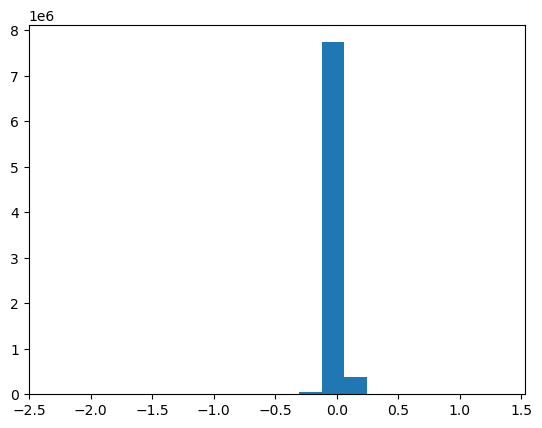

In [11]:
plt.hist(dataset[1], bins=20)

In [12]:
class MyDataset(Dataset):
    def __init__(self, data, period=600, small_period=1):
        self.data = data
        self.period = period
        self.processed_data_x = []
        self.processed_data_y = []

        for i in range(period, len(data[0]), small_period):
            self.processed_data_x.append(data[0][i-period:i, :])
            self.processed_data_y.append(data[1][i-1])

        self.processed_data_x = np.stack(self.processed_data_x, axis=0)
        self.processed_data_y = np.stack(self.processed_data_y, axis=0)

    def __len__(self) :
        return len(self.processed_data_y)

    def __getitem__(self, idx):
        return self.processed_data_x[idx, :,:], self.processed_data_y[idx, :]

In [13]:
train_data = MyDataset((dataset[0][:int(0.8*len(dataset[0])), :], dataset[1][:int(0.8*len(dataset[0])), :]), 600, 20)
val_data = MyDataset((dataset[0][int(0.8*len(dataset[0])): int(0.9*len(dataset[0])), :], dataset[1][int(0.8*len(dataset[0])): int(0.9*len(dataset[0])), :]), 600, 20)
test_data = MyDataset((dataset[0][int(0.9*len(dataset[0])):, :], dataset[1][int(0.9*len(dataset[0])):, :]), 600, 20)
print(len(train_data))
print(len(val_data))
print(len(test_data))

327254
40881
40881


In [14]:
train_data = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_data = DataLoader (val_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_data = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

![alt text](image.png)

In [15]:
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, nhead):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer_encoder(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers, nhead):
        super(TransformerDecoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, memory):
        x = self.transformer_decoder(x, memory)
        x = self.fc_out(x)
        return x

class SimLOB(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, nhead):
        super(SimLOB, self).__init__()
        self.encoder = TransformerEncoder(input_dim, hidden_dim, num_layers, nhead)
        self.decoder = TransformerDecoder(hidden_dim, output_dim, num_layers, nhead)

    def forward(self, x):
        memory = self.encoder(x)
        output = self.decoder(x, memory)
        return output

In [16]:
input_dim = 40
hidden_dim = 64
output_dim = 40
num_layers = 2
nhead = 4

model = SimLOB(input_dim, hidden_dim, output_dim, num_layers, nhead)
sample_lob = torch.randn(100, 10, input_dim)  # (sequence_length, batch_size, input_dim)
output = model(sample_lob)

AssertionError: was expecting embedding dimension of 64, but got 40

In [ ]:
# Define model, loss function, and optimizer
model = SimLOB(input_dim, hidden_dim, output_dim, num_layers, nhead)
criterion = nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, epochs=20):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            output = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss / len(train_loader)}")

train_model(model, train_data)

In [ ]:
def test_model(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            output = model(batch)
            loss = criterion(output, batch)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss / len(test_loader)}")

test_model(model, test_data)